# IMMUNE RESPONSE TO PNEUMOCCI

In [11]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
import controlSBML as ctl
import control

In [ ]:
## Immune response to pneumocci
(Based on a final project submitted by Kazuki Fukumoto to BIOEN 599, March, 2024, University of Washington)

# Helpers

In [2]:
TIMES = np.linspace(0, 120, 1200)
FIGSIZE = (5, 5)

In [3]:
def plotModel(model, times=TIMES, is_plot=False, title="", selections=None,
              figsize=(5,5), ylim=None, **kwargs):
    """
    Plots a model.

    Args:
       times: np.array
       kwargs: values of parameters
    Returns:
       NamedArray
    """
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = value
    if selections is None:
        data = rr.simulate(times[0], times[-1], len(times))
    else:
        if not "time" in selections:
            selections.insert(0, "time")
        data = rr.simulate(times[0], times[-1], len(times), selections=selections)
    if is_plot:
        if ylim is None:
            rr.plot(title=title, figsize=figsize)
        else:
            rr.plot(title=title, figsize=figsize, ylim=ylim)
    return data

# 1. Problem Statement & System Description

This model explores how the immune system responds to the infection of Pneumococci, which is the microbe associated with pneumonia. The model considers Pneumococci, susceptible epithelial cells, epithelial cells with bacteria, cytokines, neutrophils, and debris (apoptotic cellular material). The baseline simulation shows that Pneumococci are not eliminated, and all epithelial cells are eliminated. This is because the neutrophils are not produced and deployed fast enough to eliminate the infection. Even if enough neutrophils are produced, large overshoots or oscillations of neutrophils could be the factor of other health problems. To overcome these problems, I set two following control objectives.

The control objectives are:
- Shortening settling time so that neutrophils increase fast enought to eliminate Pneumococci
- Minimize the overshoot of neutrophils

## System Exploration

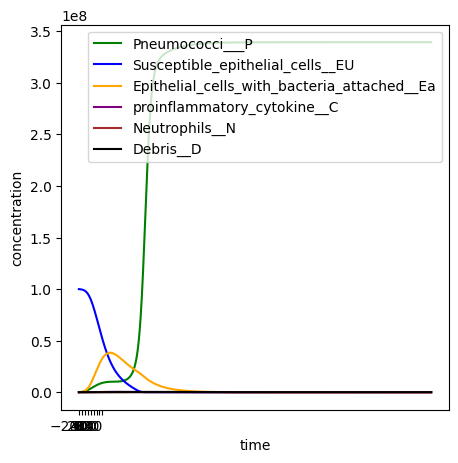

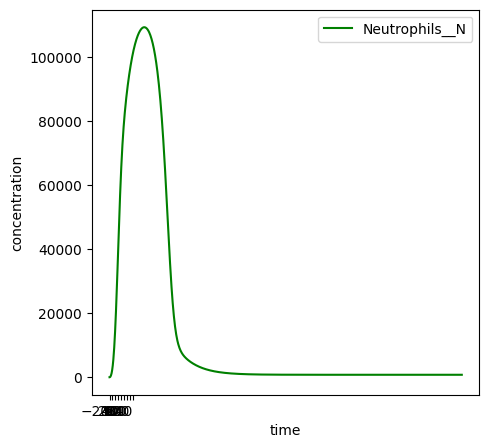

// Created by libAntimony v2.13.2
function Rate_Law_for_reaction_for__EU_decay(omega, P, Eu)
  omega*P*Eu;
end

Rate_Law_for_reaction_for__EU_decay is "Rate Law for reaction for  EU decay"

function Rate_Law_for_reaction_for_Ea_decay(d_E, Ea)
  d_E*Ea;
end

Rate_Law_for_reaction_for_Ea_decay is "Rate Law for reaction for Ea decay"

function Rate_Law_for_reaction_for_P_Decay(gamma_M_A, f_P_M_A, kd, D, M_Astar, P, gamma_N, N)
  (gamma_M_A*f_P_M_A/(1 + kd*D*M_Astar))*M_Astar*P + gamma_N*N*P;
end

Rate_Law_for_reaction_for_P_Decay is "Rate Law for reaction for P Decay"

function Rate_Law_for_reaction_for__P_production(r, P, Kp)
  r*P*(1 - P/Kp);
end

Rate_Law_for_reaction_for__P_production is "Rate Law for reaction for  P production"

function Rate_Law_for_reaction_for_C_decay(dc, C)
  dc*C;
end

Rate_Law_for_reaction_for_C_decay is "Rate Law for reaction for C decay"

function Rate_Law_for_reaction_for_C_production(alpha, Ea, kn, N, v, theta_M, M_Astar, d, k, P)
  alpha*(Ea/(1 + kn*N)) + 

In [4]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1808280007/6/Smith2011_V1.xml"
CTLSB = ctl.ControlSBML(URL, times=TIMES, is_fixed_input_species=True, figsize=FIGSIZE)
_ = CTLSB.plotModel()
_ = CTLSB.plotModel(selections=["Neutrophils__N"])
print(CTLSB.getAntimony())

## System Definition

In [5]:
INPUT_NAME = 'Pneumococci___P'
OUTPUT_NAME = 'Neutrophils__N'

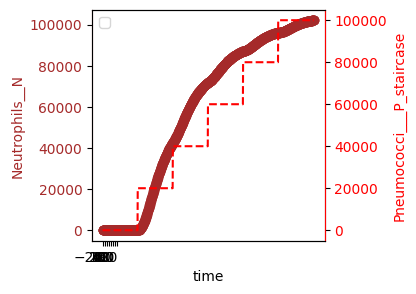

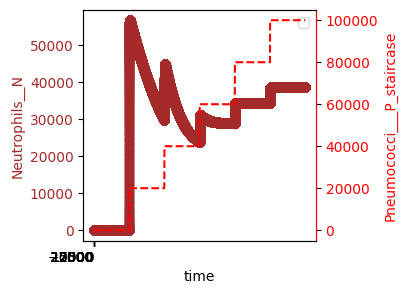

In [6]:
CTLSB = ctl.ControlSBML(URL, input_name=INPUT_NAME, output_name=OUTPUT_NAME, is_fixed_input_species=True,
                       figsize=FIGSIZE)
finalValue = 100000
#for time in [100, 1000, 10000, 20000]:
for time in [100, 20000]:
    _ = CTLSB.plotStaircaseResponse(initial_value = 0, final_value = finalValue, num_step=5, 
                                                    times=np.linspace(0, time, time*10), figsize=(3,3))

The first plot suggests that neutrophils increase with the quantity of bacteria. However, from the second plot, we see that the first plot is actually a response to the initial transient. A longer time horizon is needed to demonstrate the effect of the control input.

### Summary of the system

1. SBML model: BIOMD0000000924
1. input: Pneumococci___P (bacteria)
1. output: Neutrophils__N (leukocyte)
1. directional effect of the input on the output: increases
1. operating region for the input: [0, 100000]
1. range of outputs that can be achieved: [0, 38488]

# 2. System Identification

## Explore Transfer Functions

In [7]:
TIMES = np.linspace(0, 30000, 300000)
FINAL_VALUE = 100000
FIT_START_TIME = 10000
FIT_END_TIME = TIMES[-1]

num_zero:  0 num_pole:  2


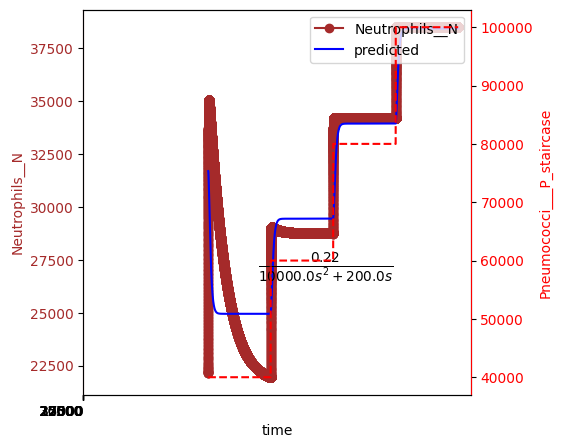

num_zero:  0 num_pole:  3


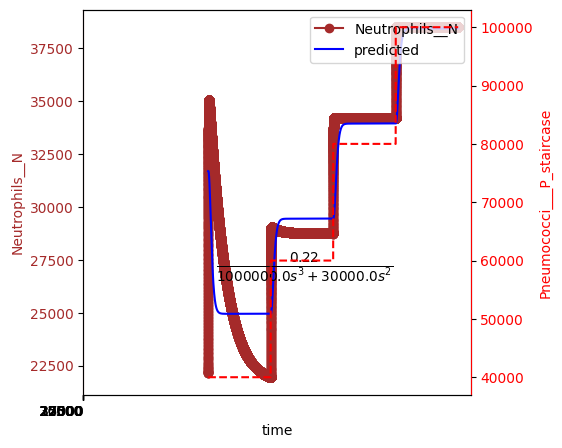

num_zero:  0 num_pole:  4


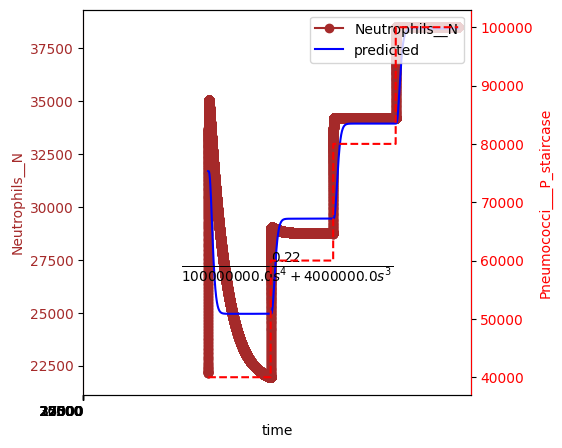

num_zero:  1 num_pole:  2


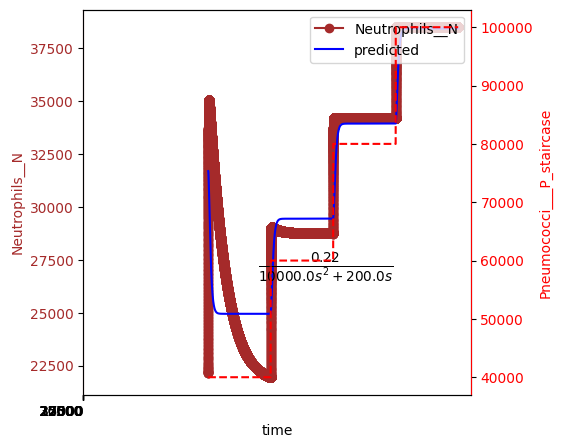

num_zero:  1 num_pole:  3


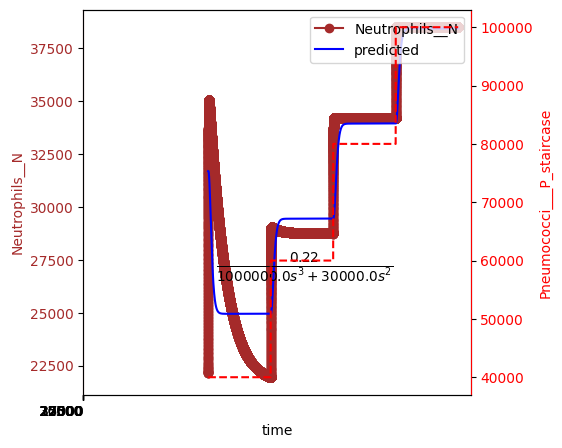

num_zero:  1 num_pole:  4


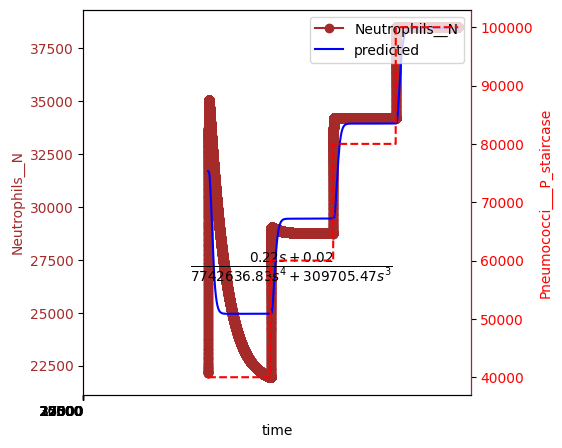

num_zero:  2 num_pole:  2


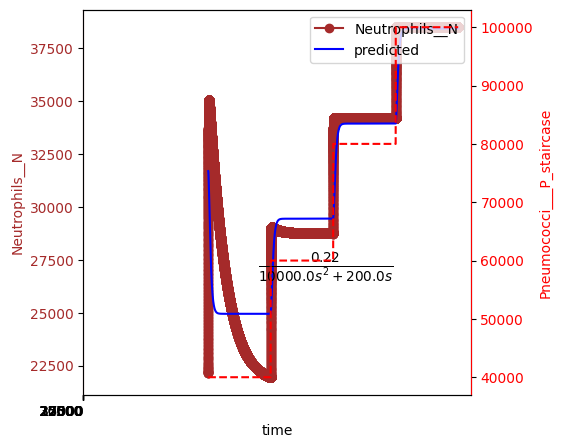

num_zero:  2 num_pole:  3


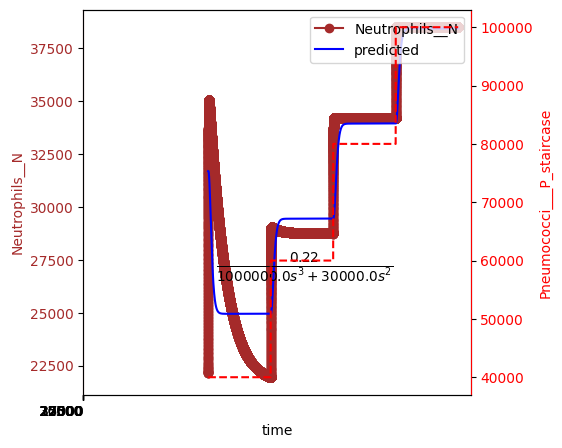

num_zero:  2 num_pole:  4


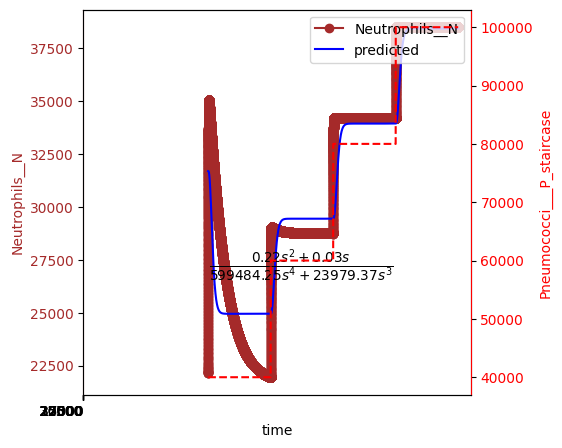

num_zero:  3 num_pole:  3


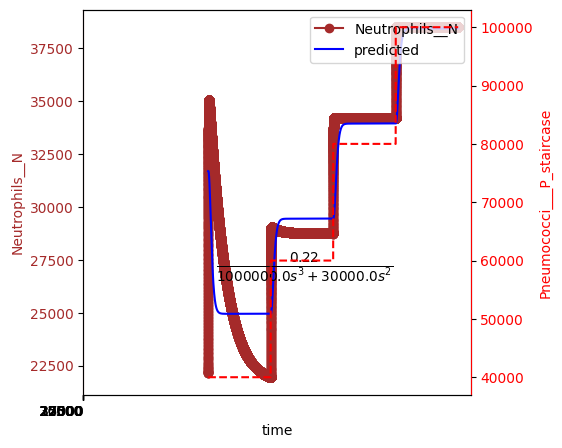

num_zero:  3 num_pole:  4


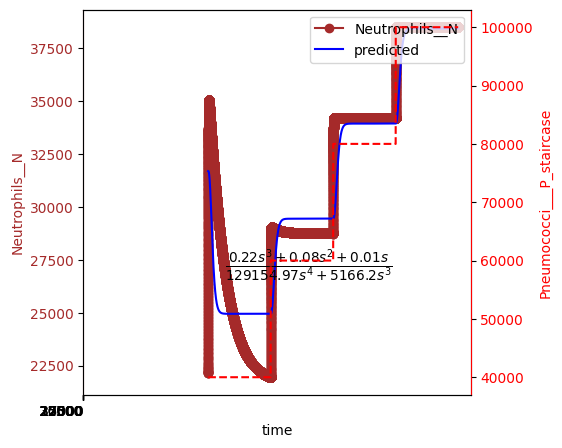

num_zero:  4 num_pole:  4


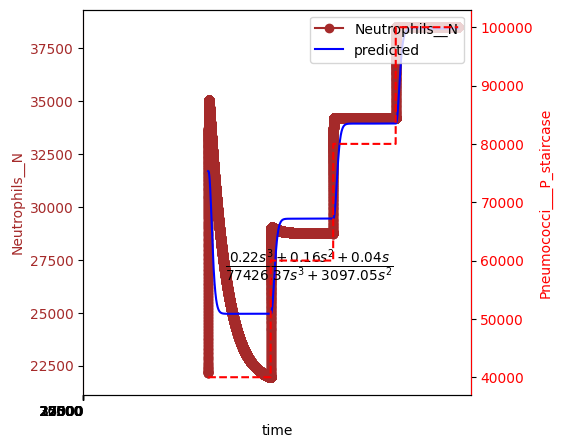

In [8]:
# Investigate possible transfer functions
for num_zero in range(5):
    for num_pole in range(2, 5):
        if num_zero > num_pole:
            continue
        print("num_zero: ", num_zero, "num_pole: ", num_pole)
        result = CTLSB.plotTransferFunctionFit(times=TIMES, 
                                               initial_value=10, final_value=FINAL_VALUE,
                                               fit_start_time=FIT_START_TIME, fit_end_time=FIT_END_TIME,
                                               num_zero=num_zero, num_pole=num_pole, fitter_method="gpz")

In [12]:
s = control.TransferFunction.s

### Transfer Function

I chose the following transfer function with one numerator and two denominator because increasing denominator or numerator didn't imporve the predictions above.

In [15]:
TRANSFER_FUNCTION

TransferFunction(array([4.21]), array([ 0.5, 10. ]))

In [14]:
TRANSFER_FUNCTION = 4.21/(0.5*s + 10)
print("poles: ", TRANSFER_FUNCTION.poles())
print("zeros: ", TRANSFER_FUNCTION.zeros())
print("DCgain: ", TRANSFER_FUNCTION.dcgain())

poles:  [-20.+0.j]
zeros:  []
DCgain:  0.42100000000000004


# 3. Control Design

## Testbed Construction

1. input: Pneumococci___P (bacteria)
1. output: Neutrophils__N (leukocyte)

In [ ]:
EU = "Susceptible_epithelial_cells__EU"
Ea = "Epithelial_cells_with_bacteria_attached__Ea"
C = "proinflammatory_cytokine__C"
N = "Neutrophils__N"
P = "Pneumococci___P"
D = "Debris__D"

In [ ]:
controllerStr = """
  // Parameters in CLS
  setpoint = 1
  kP = 1
  kI = 0
  sign = {sign}

  // Controller
  control_error := sign*(setpoint - {output_name})
  integral_control_error = 0
  integral_control_error' = control_error
  ${input_name} := kP*control_error + kI*integral_control_error
  
"""
print(controllerStr.format(sign=1, input_name="Pneumococci___P", output_name="Neutrophils__N"))

In [ ]:
input = P
output = N

lastWord = "// Notes:"
model = MODEL
insertPos= model.index(lastWord)
model_front = model[:insertPos]
model_back = model[insertPos:]
control_logic = controllerStr.format(sign=1, input_name=input, output_name=output)
control_model = model_front + control_logic + model_back
print(control_model)

In [ ]:
rr = te.loada(control_model)
rr["kP"] = 20
rr["kI"] = 0
rr["setpoint"] = 15e4
result = rr.simulate(0, 120, 1200, selections=["time", "setpoint", input, output, EU, Ea, C])

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(result["time"], result["setpoint"], label="setpoint", color="blue")
ax.plot(result["time"], result[output], label=output, color = "red")
#ax.plot(result["time"], result[input], label=input, color = "green")
ax.set_xlabel("Time")
ax.set_ylabel("Concentration")
ax.legend()
plt.show()
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(result["time"], result["setpoint"], label="setpoint", color="blue")
#ax.plot(result["time"], result[output], label=output, color = "red")
ax.plot(result["time"], result[input], label=input, color = "green")
ax.set_xlabel("Time")
ax.set_ylabel("Concentration")
ax.legend()
plt.show()


Narrative

- Control objective 1: shortening settling time so that neutrophils [N] increases fast enought to eliminate Pneumococci [P]
- Control objective 2: having no or small overshoot of neutrophils

In this design, shorter time to reach the setpoint, small overshoot of [N], and zero or negative [P] are the goal to achive. Negative [P] doesn't make sence physically, but in this case, negative [P] is good because it indicates the elimination of P. In terms of setpoint, it is based on the maximum conc. of N with the original open loop simulation. 

The design can increase [N] quickly, and [N] reaches the setpoint. Increasing kP shortens the time to reach the setpoint. Increasing kI makes the amplitude of increase smaller, and [P] is not eliminated. Therefore, kP would be more important to achive my control objective.

## Loot Rocus Analysis

### Propotional Contorl

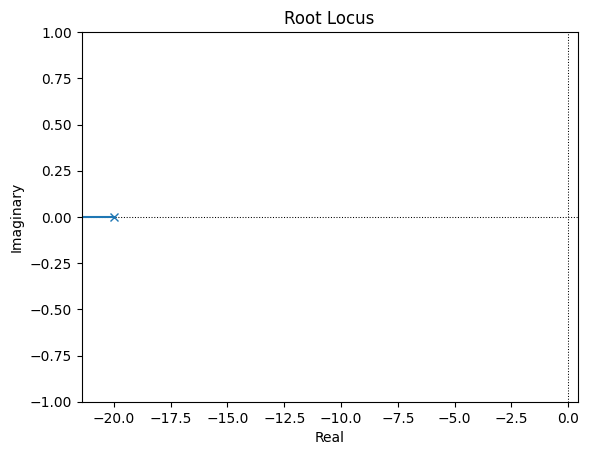

In [19]:
_ = control.root_locus(TRANSFER_FUNCTION, grid=False)

The pole is always negative, so the desing will be stable. Increasing kP would shorten the time to reach the setpoint because the pole will move to more negative side. It lies on only the real axis, so there will be no oscillations by increasing kP. The time is important to eliminate P, and kP will be a target parameter to increase.

### Integral Control

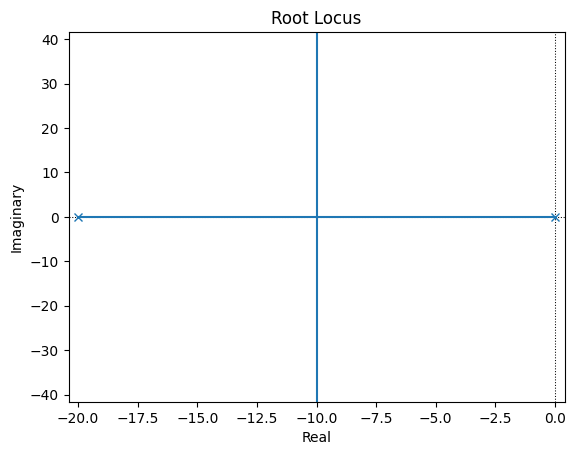

In [20]:
_ = control.root_locus(TRANSFER_FUNCTION/s, grid=False)

The pole is always negative, so the desing will be stable. Increasing kP would make the time to reach the setpoint longer because the pole will move toward -10. It diverges to infinite along the imaginary axis, so there will be oscillations by increasing kI. The time is important to eliminate P, kI will not be increased as much as kP.


## Grid Search

Criteria (order in priority)
- maximum value of N gets to the setpoint & P has to get to zero
- settling time must be smaller than 15 hrs
- minimum overshoot (small diff between the maximum N and setpoint)

In [16]:
import pandas as pd
# Set the search parameters and initialize
setpoint = 15e4
best_ks = []
kPs = range(0, 52, 1)
# make a list of logaritmic scale of kIs
a1 = [10**i for i in range(-3, 2)]
a2 = range(1,11,1)
kIs = np.outer(a1, a2).flatten().tolist()
#kPs = [1, 10, 20]
#kIs = [0, 1, 10 ,20]
settlingTime = 120
smallestOvershoot = 20000
for kI in kIs:
    for kP in kPs:
        """
        try and except are used to avoid the case where the model is not stable
        Even if the model is not stable, the grid search will continue
        """
        print("kP: ", kP, "kI: ", kI)
        try:
            data = plotModel(control_model, selections=["time", "setpoint", P, N],
                             setpoint=setpoint, kP=kP, kI=kI, is_plot=False)
        except:
            continue
        data = pd.DataFrame(data, columns=data.colnames)
        data.set_index("time", inplace=True)
        # Criteria 1
        # check if the maximum of N gets to the setpoint, and minimum of P gets equal to or less than 0
        criteria1 = (data[N].max() >= setpoint) and (data[P].min() <= 0)
        if criteria1 == False:
            continue
        else:
            # Criteria 2
            # obtain the first index where N is greater than the setpoint
            settlingT = data[N][data[N] > setpoint].index[0]
            criteria2 = settlingT < 15
            if criteria2 == False:
                continue
            else:
                # Criteria 3 
                # compare the overshoot
                overshoot = (data[N].max() - setpoint)
                if overshoot < smallestOvershoot:
                    settlingTime = settlingT
                    smallestOvershoot = overshoot
                    best_ks = [kP, kI]
        print("kP: ", kP, "kI: ", kI, "overshoot: ", overshoot, "settling time: ", settlingT)

print()
if best_ks == []:
    print("No best kP and kI")
else:
    print("best kP: ", best_ks[0], "best kI: ", best_ks[1])
    print("shortest settling time: ", settlingTime)
    print("smallest overshoot: ", smallestOvershoot)
    plotModel(control_model, selections=["time", "setpoint", P, N],setpoint=setpoint, kP=best_ks[0], kI=best_ks[1], is_plot=True)          



kP:  0 kI:  0.001
kP:  1 kI:  0.001
kP:  2 kI:  0.001
kP:  3 kI:  0.001
kP:  4 kI:  0.001
kP:  5 kI:  0.001
kP:  6 kI:  0.001
kP:  7 kI:  0.001
kP:  8 kI:  0.001
kP:  9 kI:  0.001
kP:  10 kI:  0.001
kP:  11 kI:  0.001
kP:  12 kI:  0.001
kP:  13 kI:  0.001
kP:  14 kI:  0.001
kP:  15 kI:  0.001
kP:  16 kI:  0.001
kP:  17 kI:  0.001
kP:  18 kI:  0.001
kP:  19 kI:  0.001
kP:  20 kI:  0.001
kP:  21 kI:  0.001
kP:  22 kI:  0.001
kP:  23 kI:  0.001
kP:  24 kI:  0.001
kP:  25 kI:  0.001
kP:  26 kI:  0.001
kP:  27 kI:  0.001
kP:  28 kI:  0.001
kP:  29 kI:  0.001
kP:  30 kI:  0.001
kP:  31 kI:  0.001
kP:  32 kI:  0.001
kP:  33 kI:  0.001
kP:  34 kI:  0.001
kP:  35 kI:  0.001
kP:  36 kI:  0.001
kP:  37 kI:  0.001
kP:  38 kI:  0.001
kP:  39 kI:  0.001
kP:  40 kI:  0.001
kP:  41 kI:  0.001
kP:  42 kI:  0.001
kP:  43 kI:  0.001
kP:  44 kI:  0.001
kP:  45 kI:  0.001
kP:  46 kI:  0.001
kP:  47 kI:  0.001
kP:  48 kI:  0.001
kP:  49 kI:  0.001
kP:  50 kI:  0.001
kP:  51 kI:  0.001
kP:  0 kI:  0.002
kP: 

In [ ]:
(950/15e4)*100

Best parameters
- kP: 17
- kI: 0.04

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]


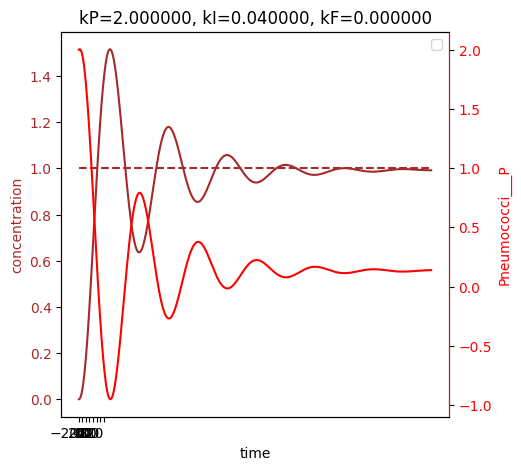

DesignResult(timeseries=             Pneumococci___P  Neutrophils__N
miliseconds                                 
0                   2.000000        0.000000
200                 2.004857        0.001577
400                 2.002936        0.006531
601                 1.993694        0.015118
801                 1.976762        0.027508
...                      ...             ...
99198               0.138191        0.991840
99398               0.138332        0.991802
99599               0.138444        0.991779
99799               0.138527        0.991771
100000              0.138582        0.991776

[500 rows x 2 columns], antimony_builder=// Created by libAntimony v2.13.2
function Rate_Law_for_reaction_for__EU_decay(omega, P, Eu)
  omega*P*Eu;
end

Rate_Law_for_reaction_for__EU_decay is "Rate Law for reaction for  EU decay"

function Rate_Law_for_reaction_for_Ea_decay(d_E, Ea)
  d_E*Ea;
end

Rate_Law_for_reaction_for_Ea_decay is "Rate Law for reaction for Ea decay"

function Rate_L

In [28]:
CTLSB.plotDesign(kP_spec=2, kI_spec=0.04, times=np.linspace(0, 100, 500))

The time was 7.2 hrs, which was about half of the time of the original open loop system. The overshoot was about 950. It is 0.63% of the setpoint. Using the best paramters, P. was eliminated and N. increased in short time with a small overshoot, and the control objectives were complited. However, the initial [P] was out of the operating region.

# 4. Discussion

Challenge: Grid search was challenging to me. I struggled to interpret my control objectives into the coditions to choose the best parameters because I had to compare and decide how well each design completes objectives over other designs rather than checking one design against objectives. After I set up, I struggled to make them into python codes. Especially, priotalizing conditions was hard because of nested if statements.

Helpful tool: I found loot rocus plots are very useful to estimate the possible range of design parameter. Based on the estimation, I set up the range for grid search and reduced total computation time. In terms of python method, ctlsb.plotTransferFunctionFit() was helpful because it enabled to explore transfer functions with a few codes. Using for-loops, it was very easy to find the best transfer function.